<a href="https://colab.research.google.com/github/shwehan/ZC-midterm23/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data is from
https://www.kaggle.com/datasets/ealaxi/paysim1/data

In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [7]:
!kaggle datasets download -d ealaxi/paysim1

paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
from zipfile import ZipFile
file_name = "/content/paysim1.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="Set2")
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve,auc )
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv(r"/content/PS_20174392719_1491204439457_log.csv")

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [13]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [14]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df.shape

(6362620, 11)

In [17]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [18]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [19]:
type = df['type'].value_counts()
transaction = type.index
count = type.values
count

array([2237500, 2151495, 1399284,  532909,   41432])

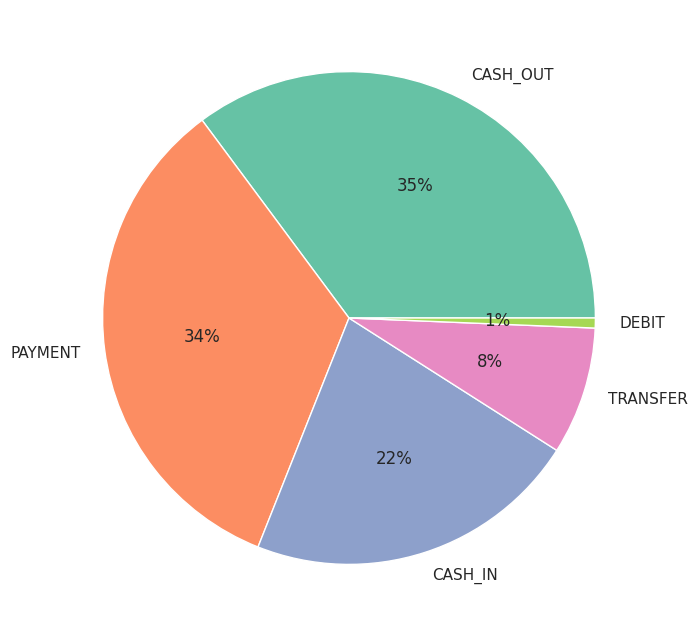

In [20]:
# drawing piechart
plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.show()

In [21]:
fraud, nonfraud = df[df["isFraud"] == 1], df[df["isFraud"] == 0]

In [22]:
df['nameDest'].nunique()

2722362

In [23]:
df['nameOrig'].nunique()

6353307

In [24]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [35]:
df_new = df.drop(["isFlaggedFraud",'nameOrig','nameDest'],1)
df_new.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [36]:
df_new=pd.get_dummies(df_new,prefix=['type'],drop_first=True)
df_new.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [37]:
X = df_new.drop("isFraud",1)
y = df_new.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = MinMaxScaler()

# Fit only to the training data
X_train=scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
5366282,375,19521.10,20590.00,1068.90,0.00,19521.10,1,0,0,0
2420161,202,295941.94,878482.10,1174424.05,1843557.41,1547615.47,0,0,0,0
3019914,233,287487.10,649832.95,937320.06,514311.71,226824.61,0,0,0,0
3076526,235,19464.09,5629.00,0.00,419585.29,439049.38,1,0,0,0
4377559,311,14662.54,0.00,0.00,0.00,0.00,0,0,1,0


In [39]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2)

In [40]:
X_res, y_res = rus.fit_resample(X_train, y_train)

In [41]:
LR = LogisticRegression()
LR.fit(X_res, y_res)
y_pred = LR.predict(X_test)
y_predtrain = LR.predict(X_train)
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
CM_LRtrain = confusion_matrix(y_train,y_predtrain)
CR_LRtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)
print("Confusion Matrix Train:\n",CM_LRtrain)
print("Classification Report Train:\n",CR_LRtrain)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.9721435509271338
Confusion Matrix:
 [[1544729   43837]
 [    473    1616]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1588566
           1       0.04      0.77      0.07      2089

    accuracy                           0.97   1590655
   macro avg       0.52      0.87      0.53   1590655
weighted avg       1.00      0.97      0.98   1590655

Confusion Matrix Train:
 [[4632845  132996]
 [   1340    4784]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   4765841
           1       0.03      0.78      0.07      6124

    accuracy                           0.97   4771965
   macro avg       0.52      0.88      0.53   4771965
weighted avg       1.00      0.97      0.98   4771965

Precision: 0.03555320880909951
Recall: 0.7735758736237435
F1: 0.06798199486769593
Area under precision (AUC) Recall: 0.027800466343264885


In [42]:
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)
print("Confusion Matrix Train Data:\n",CM_LRtrain)
print("Classification Report Train Data:\n",CR_LRtrain)

Confusion Matrix:
 [[1544729   43837]
 [    473    1616]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1588566
           1       0.04      0.77      0.07      2089

    accuracy                           0.97   1590655
   macro avg       0.52      0.87      0.53   1590655
weighted avg       1.00      0.97      0.98   1590655

Confusion Matrix Train Data:
 [[4632845  132996]
 [   1340    4784]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   4765841
           1       0.03      0.78      0.07      6124

    accuracy                           0.97   4771965
   macro avg       0.52      0.88      0.53   4771965
weighted avg       1.00      0.97      0.98   4771965



In [43]:
#Random Forest
RF = RandomForestClassifier(n_estimators=15,oob_score=True,class_weight='balanced',n_jobs=-1)


RF.fit(X_train, y_train)

y_pred= RF.predict(X_test)
y_predtrain=RF.predict(X_train)

# Evaluating model
CM_RF_train=confusion_matrix(y_train,y_predtrain)
CR_RF_train= classification_report(y_train,y_predtrain)
CM_RF = confusion_matrix(y_test,y_pred)
CR_RF = classification_report(y_test,y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_RF)
print("Classification Report:\n",CR_RF)
print("Confusion Matrix Train Data:\n",CM_RF_train)
print("Classification Report Train Data:\n",CR_RF_train)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.9996724619732122
Confusion Matrix:
 [[1588528      38]
 [    483    1606]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588566
           1       0.98      0.77      0.86      2089

    accuracy                           1.00   1590655
   macro avg       0.99      0.88      0.93   1590655
weighted avg       1.00      1.00      1.00   1590655

Confusion Matrix Train Data:
 [[4765837       4]
 [    115    6009]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4765841
           1       1.00      0.98      0.99      6124

    accuracy                           1.00   4771965
   macro avg       1.00      0.99      1.00   4771965
weighted avg       1.00      1.00      1.00   4771965

Precision: 0.9768856447688564
Recall: 0.7687888942077549
F1: 0.8604339673185105
Area under precision (AUC) Recall: 0.75132248310628

In [44]:
# XGboost
weights = (y==0).sum()/(1.0 *  (y==1).sum())
XGB= xgb_classifier1 = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
XGB.fit(X_train, y_train)

y_pred= XGB.predict(X_test)
y_predtrain=XGB.predict(X_train)


In [45]:
# Evaluating model
CM_XGB_train=confusion_matrix(y_train,y_predtrain)
CR_XGB_train= classification_report(y_train,y_predtrain)
CM_XGB = confusion_matrix(y_test,y_pred)
CR_XGB = classification_report(y_test,y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_XGB)
print("Classification Report:\n",CR_XGB)
print("Confusion Matrix Train Data:\n",CM_XGB_train)
print("Classification Report Train Data:\n",CR_XGB_train)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.9923559791406684
Confusion Matrix:
 [[1576415   12151]
 [      8    2081]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588566
           1       0.15      1.00      0.26      2089

    accuracy                           0.99   1590655
   macro avg       0.57      0.99      0.63   1590655
weighted avg       1.00      0.99      1.00   1590655

Confusion Matrix Train Data:
 [[4729192   36649]
 [     10    6114]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   4765841
           1       0.14      1.00      0.25      6124

    accuracy                           0.99   4771965
   macro avg       0.57      1.00      0.62   4771965
weighted avg       1.00      0.99      1.00   4771965

Precision: 0.14621978639685215
Recall: 0.9961704164672092
F1: 0.25500888425954293
Area under precision (AUC) Recall: 0.145664854885

In [46]:
# Selecting Model

#Random Forest performed the best; I would still need to parameter tuning but as of far RF performs the best.
model = RandomForestClassifier(n_estimators=15,oob_score=True,class_weight='balanced',n_jobs=-1)


model.fit(X_train, y_train)

y_pred= model.predict(X_test)
y_predtrain=model.predict(X_train)


In [47]:
# SAVE model

import pickle

In [48]:
output_file = f'fraud_model.bin'
output_file

'fraud_model.bin'

In [49]:
f_out = open(output_file, 'wb')
pickle.dump(model, f_out)
f_out.close()

In [50]:
with open(output_file, 'wb') as f_out:
  pickle.dump(model, f_out)


In [51]:
!ls -lh *.bin

-rw-r--r-- 1 root root 78M Nov  6 04:59 fraud_model.bin


In [52]:
with open(output_file, 'wb') as f_out:
    pickle.dump(model, f_out)

In [53]:
# LOAD the model

model_file = 'fraud_model.bin'

In [54]:
with open(model_file, 'rb') as f_in:
  model = pickle.load(f_in)

In [55]:
model

RandomForestClassifier(class_weight='balanced', n_estimators=15, n_jobs=-1,
                       oob_score=True)

In [56]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0


In [57]:
#step	type	amount	nameOrig	oldbalanceOrg	newbalanceOrig	nameDest	oldbalanceDest	newbalanceDest	isFraud	isFlaggedFraud
#2	1	TRANSFER	181.00	C1305486145	181.0	0.00	C553264065	0.0	0.0	1	0
input = pd.DataFrame(
    dict(
        step=[2],
        amount=[181.0],
        oldbalanceOrg=[181.0],
        newbalanceOrig=[0.00],
        oldbalanceDest=[0.00],
        newbalanceDest=[0.00],
        type_CASH_OUT=[0],
        type_DEBIT=[0],
        type_PAYMENT=[0],
        type_TRANSFER=[1]
    ))
input

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,2,181.0,181.0,0.0,0.0,0.0,0,0,0,1


In [58]:

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = MinMaxScaler()

# Fit only to the training data
X_train=scaler.fit_transform(X_train)

input = scaler.transform(input)

In [59]:
y_pred = model.predict_proba(input)[0, 1]

In [60]:
y_pred

0.2

In [ ]:
# Flask set up

In [ ]:
!pip install pyngrok

In [ ]:
import getpass

from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect("22", "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

In [ ]:
import os
import threading

from flask import Flask
from pyngrok import ngrok

app = Flask(__name__)
port = "5000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/")
def index():
    return "Hello from Zoomcamp Mid!"

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

In [ ]:
import requests

In [ ]:
url = 'https://8c6d-34-148-157-138.ngrok-free.app/'